In [ ]:
!apt-get update
!apt-get install -y cmake libboost-all-dev liblua5.1-0-dev
!pip install vizdoom


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,853 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,147 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/

In [ ]:
# Dueling DQN Agent for ViZDoom (Improved Version)

from google.colab import drive
import os
import numpy as np
import random
import cv2
import pickle
import gdown
import matplotlib.pyplot as plt
from collections import deque
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Lambda, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from vizdoom import *
from moviepy.editor import ImageSequenceClip
from google.colab import output



  if event.key is 'enter':



In [ ]:
# Подключение Google Диска
MODEL_PATH = "/content/drive/My Drive/pretrained_networks/"
drive.mount('/content/drive')
os.makedirs(MODEL_PATH, exist_ok=True)


Mounted at /content/drive


In [ ]:
# Скачиваем и распаковываем данные
if not os.path.exists("/content/ViZDoom"):
    gdown.download('https://storage.yandexcloud.net/aiueducation/Content/advanced/l6/rl.zip', output = 'rl.zip', quiet = False)
    !unzip -qo rl.zip -d /content/ViZDoom/


Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/advanced/l6/rl.zip
To: /content/rl.zip
100%|██████████| 11.5M/11.5M [00:01<00:00, 7.69MB/s]


In [ ]:
# === Конфигурация ===
CONFIG_PATH = "/content/ViZDoom/rl/scenarios/basic.cfg"
WAD_PATH = "/content/ViZDoom/rl/scenarios/basic.wad"


In [ ]:
# === Гиперпараметры ===
STATE_SHAPE = (64, 64, 3)
ACTION_SIZE = 3
MEMORY_SIZE = 50000
BATCH_SIZE = 64
GAMMA = 0.99
LEARNING_RATE = 0.00025
EPSILON = 1.0
EPSILON_MIN = 0.1
EPSILON_DECAY = 0.999
TARGET_UPDATE_FREQ = 10
EPISODES = 500


In [ ]:
# Действия в виде one-hot
ACTIONS = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]


In [ ]:
# === Инициализация среды ===
def init_vizdoom():
    game = DoomGame()
    game.load_config(CONFIG_PATH)
    game.set_doom_scenario_path(WAD_PATH)
    game.set_window_visible(False)
    game.init()
    return game

def preprocess_frame(frame):
    frame = np.moveaxis(frame, 0, -1) if frame.shape[0] in [1, 3] else frame
    frame = cv2.resize(frame, (64, 64))
    if frame.shape[-1] != 3:
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    return frame.astype(np.float32) / 255.0

def build_dueling_dqn(input_shape, action_size, learning_rate):
    state_input = Input(shape=input_shape)
    x = Conv2D(32, 4, strides=2, activation='relu')(state_input)
    x = Conv2D(48, 3, strides=2, activation='relu')(x)
    x = Conv2D(64, 3, strides=2, activation='relu')(x)
    x = Conv2D(96, 3, strides=2, activation='relu')(x)
    x = Flatten()(x)

    state_value = Dense(256, activation='relu')(x)
    state_value = Dense(1)(state_value)

    action_advantage = Dense(256, activation='relu')(x)
    action_advantage = Dense(action_size)(action_advantage)
    action_advantage = Lambda(lambda a: a - K.mean(a, keepdims=True))(action_advantage)

    q_values = Add()([state_value, action_advantage])
    model = Model(inputs=state_input, outputs=q_values)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

def train_model(model, target_model, memory):
    if len(memory) < BATCH_SIZE:
        return
    batch = random.sample(memory, BATCH_SIZE)
    states, next_states = [], []
    for state, _, _, next_state, _ in batch:
        states.append(state)
        next_states.append(next_state)

    states = np.array(states)
    next_states = np.array(next_states)

    q_values = model.predict(states, verbose=0)
    q_next = target_model.predict(next_states, verbose=0)

    for i, (_, action, reward, _, done) in enumerate(batch):
        q_values[i][action] = reward if done else reward + GAMMA * np.max(q_next[i])

    model.fit(states, q_values, epochs=1, verbose=0)

def get_action(model, state, epsilon):
    if np.random.rand() <= epsilon:
        return random.randrange(ACTION_SIZE)
    q_values = model.predict(np.expand_dims(state, axis=0), verbose=0)[0]
    return np.argmax(q_values)

def get_state(game):
    frame = game.get_state().screen_buffer
    return preprocess_frame(frame)

def save_video(frames, filename="result.mp4"):
    clip = ImageSequenceClip(frames, fps=20)
    clip.write_videofile(filename)
    output.eval_js(f"""
        var video = document.createElement('video');
        video.src = "{filename}";
        video.controls = true;
        video.autoplay = true;
        video.style.maxHeight = "400px";
        document.body.appendChild(video);
    """)


In [ ]:
import os
import pickle
from collections import deque

# === Пути сохранения ===
SAVE_PATH = "/content/drive/MyDrive/vizdoom_checkpoint"  # Измени путь под себя
os.makedirs(SAVE_PATH, exist_ok=True)
checkpoint_file = os.path.join(SAVE_PATH, "training_state.pkl")
weights_file = os.path.join(SAVE_PATH, "dueling_dqn.weights.h5")

# === Инициализация модели и окружения ===
model = build_dueling_dqn(STATE_SHAPE, ACTION_SIZE, LEARNING_RATE)
target_model = build_dueling_dqn(STATE_SHAPE, ACTION_SIZE, LEARNING_RATE)
memory = deque(maxlen=MEMORY_SIZE)

# === Стартовые значения ===
start_episode = 0
epsilon = EPSILON
best_reward = -np.inf
rewards_history = []

# === Попытка загрузить прогресс ===
if os.path.exists(checkpoint_file) and os.path.exists(weights_file):
    with open(checkpoint_file, "rb") as f:
        checkpoint = pickle.load(f)
    model.load_weights(weights_file)
    target_model.set_weights(model.get_weights())
    epsilon = checkpoint["epsilon"]
    best_reward = checkpoint["best_reward"]
    rewards_history = checkpoint["rewards_history"]
    start_episode = checkpoint["episode"] + 1
    print(f"✅ Прогресс загружен: продолжение с эпизода {start_episode}")
else:
    print("🚀 Начинаем обучение с нуля")

# === Запуск игры ===
game = init_vizdoom()

# === Основной цикл обучения ===
for episode in range(start_episode, EPISODES):
    game.new_episode()
    state = get_state(game)
    total_reward = 0
    frames = []

    while not game.is_episode_finished():
        action_idx = get_action(model, state, epsilon)
        reward = game.make_action(ACTIONS[action_idx])
        done = game.is_episode_finished()
        next_state = get_state(game) if not done else np.zeros(STATE_SHAPE)
        memory.append((state, action_idx, reward, next_state, done))
        train_model(model, target_model, memory)
        state = next_state
        total_reward += reward
        frames.append((state * 255).astype(np.uint8))

    if episode % TARGET_UPDATE_FREQ == 0:
        target_model.set_weights(model.get_weights())

    if total_reward > best_reward:
        best_reward = total_reward
        model.save(os.path.join(SAVE_PATH, "best_dueling_dqn.keras"))  # Новый формат

    epsilon = max(EPSILON_MIN, epsilon * EPSILON_DECAY)
    rewards_history.append(total_reward)
    print(f"Episode {episode}: Total Reward = {total_reward:.2f}, Epsilon = {epsilon:.3f}")

    # === Сохраняем прогресс ===
    checkpoint_data = {
        "epsilon": epsilon,
        "best_reward": best_reward,
        "rewards_history": rewards_history,
        "episode": episode
    }
    model.save_weights(weights_file)
    with open(checkpoint_file, "wb") as f:
        pickle.dump(checkpoint_data, f)


    last_episode_frames = frames

✅ Прогресс загружен: продолжение с эпизода 500


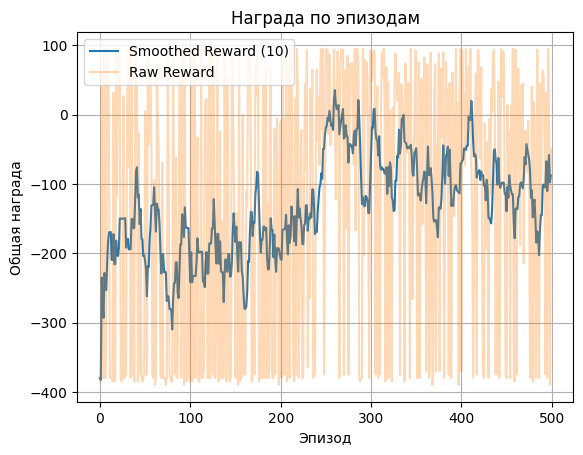

In [ ]:
# === Сохраняем последнюю модель ===
model.save(os.path.join(MODEL_PATH, "last_dueling_dqn_vizdoom.keras"))

# === График сглаженной награды ===
smoothed_rewards = [np.mean(rewards_history[max(0, i-10):i+1]) for i in range(len(rewards_history))]
plt.plot(smoothed_rewards, label='Smoothed Reward (10)')
plt.plot(rewards_history, alpha=0.3, label='Raw Reward')
plt.title("Награда по эпизодам")
plt.xlabel("Эпизод")
plt.ylabel("Общая награда")
plt.legend()
plt.grid(True)
plt.show()

game.close()